In [1]:
!pip install transformers
!pip install openprompt
import torch
import pickle
import pandas as pd
import torch.nn.functional as F
import random
import transformers
import numpy as np
import torch.nn as nn
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.metrics import classification_report, f1_score
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch.utils.data import Dataset
from torch.optim import AdamW

from openprompt.prompts import PTRTemplate, PTRVerbalizer, MixedTemplate, KnowledgeableVerbalizer
from openprompt.plms import load_plm
from openprompt.data_utils import InputExample
from openprompt import PromptForClassification, PromptModel
from openprompt import PromptDataLoader


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [ ]:
device = torch.device('cuda')

In [ ]:
class ProgressPlotter:
  def __init__(self,title = None) -> None:
    self._history_dict = defaultdict(list)
    self.title = title

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))

  """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """
  def display(self,groups = None):
    clear_output()
    if groups is None:
      groups = self._history_dict.keys()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    fig.suptitle(self.title)
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys)
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

In [ ]:
from transformers import RobertaTokenizer, RobertaModel

tokenizer = RobertaTokenizer.from_pretrained("ai-forever/ruRoberta-large")

model = RobertaModel.from_pretrained("sberbank-ai/ruRoberta-large")
device = torch.device('cuda')

Some weights of the model checkpoint at sberbank-ai/ruRoberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Data Statistics

In [2]:
df = pd.read_csv('tsa_dataset.csv', sep='\t')

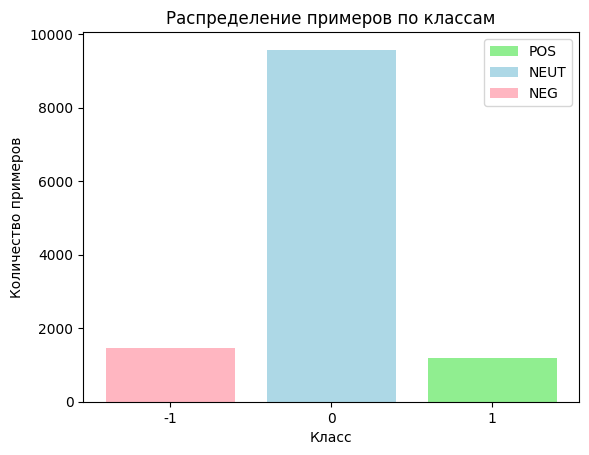

In [3]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('Класс')
plt.ylabel('Количество примеров')
plt.title('Распределение примеров по классам')
plt.bar(1, df[df['label'] == 1].shape, label='POS', color='lightgreen')
plt.bar(0, df[df['label'] == 0].shape, label='NEUT', color='lightblue')
plt.bar(-1, df[df['label'] == -1].shape, label='NEG', color='lightpink')
plt.xticks(ticks=[1, 0, -1], labels=['1', '0', '-1'])
plt.legend()
plt.savefig('200dpi.png', dpi=200)
plt.show()


# Open Prompt Mixed Template

In [ ]:
!pip install openprompt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
device = torch.device('cuda')

In [ ]:
from openprompt.data_utils import InputExample

In [ ]:
from openprompt.plms import load_plm
plm, tokenizer, model_config, WrapperClass = load_plm("roberta", "sberbank-ai/ruRoberta-large")

In [ ]:
train_1 = pd.read_csv('tsa_dataset_1_train.csv', sep='\t')
test_1 = pd.read_csv('tsa_dataset_1_test.csv', sep='\t')
train_2 = pd.read_csv('tsa_dataset_2_train.csv', sep='\t')
test_2 = pd.read_csv('tsa_dataset_2_test.csv', sep='\t')
train_3 = pd.read_csv('tsa_dataset_3_train.csv', sep='\t')
test_3 = pd.read_csv('tsa_dataset_3_test.csv', sep='\t')

"\ntrain_1 = pd.read_csv('tsa_dataset_1_train.csv', sep='\t')\ntest_1 = pd.read_csv('tsa_dataset_1_test.csv', sep='\t')\ntrain_2 = pd.read_csv('tsa_dataset_2_train.csv', sep='\t')\ntest_2 = pd.read_csv('tsa_dataset_2_test.csv', sep='\t')\ntrain_3 = pd.read_csv('tsa_dataset_3_train.csv', sep='\t')\ntest_3 = pd.read_csv('tsa_dataset_3_test.csv', sep='\t')\n"

In [ ]:
train_1['label']= train_1['label'].replace([-1, 0, 1], [1, 0, 2])
test_1['label']= test_1['label'].replace([-1, 0, 1], [1, 0, 2])
train_2['label']= train_2['label'].replace([-1, 0, 1], [1, 0, 2])
test_2['label']= test_2['label'].replace([-1, 0, 1], [1, 0, 2])
train_3['label']= train_3['label'].replace([-1, 0, 1], [1, 0, 2])
test_3['label']= test_3['label'].replace([-1, 0, 1], [1, 0, 2])


"\ntrain_1['label']= train_1['label'].replace([-1, 0, 1], [1, 0, 2])\ntest_1['label']= test_1['label'].replace([-1, 0, 1], [1, 0, 2])\ntrain_2['label']= train_2['label'].replace([-1, 0, 1], [1, 0, 2])\ntest_2['label']= test_2['label'].replace([-1, 0, 1], [1, 0, 2])\ntrain_3['label']= train_3['label'].replace([-1, 0, 1], [1, 0, 2])\ntest_3['label']= test_3['label'].replace([-1, 0, 1], [1, 0, 2])\n"

In [ ]:
splits = [[train_1, train_2, train_3], [test_1, test_2, test_3]]

In [ ]:
train_datasets = []
test_datasets = []
for split in splits[0]:
  dataset_train = []
  for i, sentence in enumerate(split['sentence']):
    entity = split['entity'][i]
    label = split['label'][i]
    dataset_train.append(InputExample(text_a=entity, text_b=sentence, label=label, guid=i))
  train_datasets.append(dataset_train)

for split in splits[1]:
  dataset_test = []
  for i, sentence in enumerate(split['sentence']):
    entity = split['entity'][i]
    label = split['label'][i]
    dataset_test.append(InputExample(text_a=entity, text_b=sentence, label=label, guid=i))
  test_datasets.append(dataset_test)

In [ ]:
from openprompt.prompts import MixedTemplate

In [ ]:
prompt = MixedTemplate(
    model=plm, tokenizer=tokenizer, text='{"soft": "Какое отношение выражено к"} {"placeholder":"text_a"} {"soft": "в предложении "} {"placeholder":"text_b"}: {"text": "отрицательное, положительное или нейтрально"}? {"soft": "Отношение в данном предложении к"}{"placeholder":"text_a"}{"mask"}'
    )

In [ ]:
wrapped_example = prompt.wrap_one_example(train_datasets[1][0])
print(wrapped_example)

[[{'text': 'ÐļÐ°ÐºÐ¾Ðµ', 'soft_token_ids': 1, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': 'ĠÐ¾ÑĤÐ½Ð¾ÑĪÐµÐ½Ð¸Ðµ', 'soft_token_ids': 2, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': 'ĠÐ²ÑĭÑĢÐ°Ð¶', 'soft_token_ids': 3, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': 'ÐµÐ½Ð¾', 'soft_token_ids': 4, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': 'ĠÐº', 'soft_token_ids': 5, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': ' Бигнов', 'soft_token_ids': 0, 'loss_ids': 0, 'shortenable_ids': 1}, {'text': 'ĠÐ²', 'soft_token_ids': 6, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': 'ĠÐ¿ÑĢÐµÐ´Ð»Ð¾Ð¶ÐµÐ½Ð¸Ð¸', 'soft_token_ids': 7, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': 'Ġ', 'soft_token_ids': 8, 'loss_ids': 0, 'shortenable_ids': 0}, {'text': ' "Для Москвы эта фигура может оказаться более приемлемой, чем Сарбаев, исходя хотя бы из его русской национальности и большого опыта экономического управления",-заявил господин Бигнов.', 'soft_token_ids': 0, 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ':

In [ ]:
wrapped_tokenizer = WrapperClass(max_seq_length=200, tokenizer=tokenizer)

In [ ]:
from openprompt import PromptDataLoader

In [ ]:
train_dataloader = PromptDataLoader(
    dataset=dataset_train,
    template=prompt,
    tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass,
    max_seq_length=200,
    batch_size=16,
    teacher_forcing=False,
    predict_eos_token=False,
    truncate_method='balanced'
)

tokenizing: 6637it [00:13, 498.71it/s]


In [ ]:
from openprompt.prompts import ManualVerbalizer

In [ ]:
verbalizer = ManualVerbalizer(
    tokenizer=tokenizer,
    num_classes=3,
    label_words=[['негативно', 'негативное', 'отрицательно', 'отрицательное', 'плохо', 'плохое'], ['нейтрально', 'нейтральное', 'никак'], ['позитивное', 'позитивно', 'положительно', 'положительное', 'хорошо', 'хорошее']]
    )

In [ ]:
from openprompt import PromptForClassification

In [ ]:
from transformers import get_linear_schedule_with_warmup

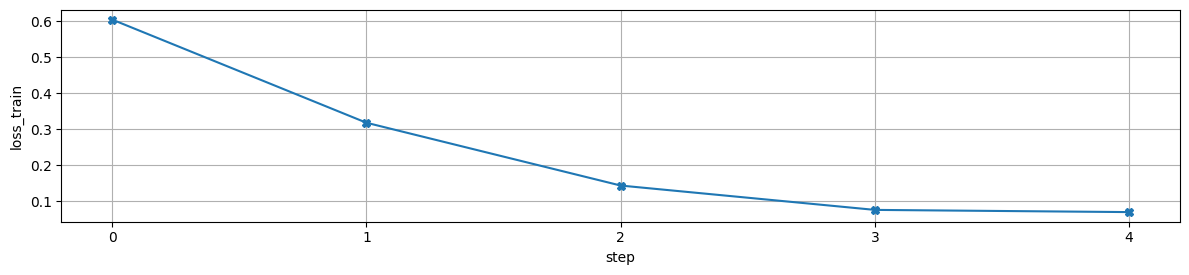

CPU times: user 57min 24s, sys: 6min 34s, total: 1h 3min 59s
Wall time: 1h 3min 46s


'\n  validation_dataloader = PromptDataLoader(dataset=test_datasets[i], template=prompt, tokenizer=tokenizer,\n  tokenizer_wrapper_class=WrapperClass, max_seq_length=200,\n    batch_size=4, shuffle=False, teacher_forcing=False, predict_eos_token=False,\n    truncate_method="balanced")\n  allpreds = []\n  alllabels = []\n  for step, inputs in enumerate(validation_dataloader):\n    inputs = inputs.to(device)\n    logits = prompt_model(inputs)\n    labels = inputs[\'label\']\n    alllabels.extend(labels.cpu().tolist())\n    allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())\n  report = classification_report(alllabels, allpreds, output_dict=True)\n  print(report)\n  reports.append(report) \n'

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
reports = []

for i in range(3):
 if i == 0:
  plm, tokenizer, model_config, WrapperClass = load_plm("roberta", "sberbank-ai/ruRoberta-large")
  train_dataloader = PromptDataLoader(
      dataset=train_datasets[i],
      template=prompt,
      tokenizer=tokenizer,
      tokenizer_wrapper_class=WrapperClass,
      max_seq_length=200,
      batch_size=16,
      teacher_forcing=False,
      predict_eos_token=False,
      truncate_method='balanced',
      shuffle=True
  )
  prompt_model = PromptForClassification(plm=plm, template=prompt, verbalizer=verbalizer, freeze_plm=False)
  prompt_model = prompt_model.to(device)
  loss_func = torch.nn.CrossEntropyLoss()
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters1 = [
    {'params': [p for n, p in prompt_model.plm.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in prompt_model.plm.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
  ]
  optimizer_grouped_parameters2 = [
    {'params': [p for n,p in prompt_model.template.named_parameters() if "raw_embedding" not in n]}
  ]
  optimizer1 = AdamW(optimizer_grouped_parameters1, lr=2e-5)
  optimizer2 = AdamW(optimizer_grouped_parameters2, lr=2e-4)
  print(f'Split {i+1}')
  print('-' * 5)
  pp = ProgressPlotter()
  for epoch in range(5):
    total_loss = []
    print('Epoch: ', epoch)
    for step, inputs in enumerate(train_dataloader):
            inputs = inputs.cuda()
            logits = prompt_model(inputs)
            labels = inputs['label']
            loss = loss_func(logits, labels)
            loss.backward()
            total_loss.append(loss.item())
            optimizer1.step()
            optimizer1.zero_grad()
            optimizer2.step()
            optimizer2.zero_grad()
    pp.add_scalar('loss_train', np.mean(total_loss))
    pp.display([['loss_train']])

  validation_dataloader = PromptDataLoader(dataset=test_datasets[i], template=prompt, tokenizer=tokenizer,
  tokenizer_wrapper_class=WrapperClass, max_seq_length=200,
    batch_size=4, shuffle=False, teacher_forcing=False, predict_eos_token=False,
    truncate_method="balanced")
  allpreds = []
  alllabels = []
  for step, inputs in enumerate(validation_dataloader):
    inputs = inputs.to(device)
    logits = prompt_model(inputs)
    labels = inputs['label']
    alllabels.extend(labels.cpu().tolist())
    allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())
  report = classification_report(alllabels, allpreds, output_dict=True)
  print(report)
  reports.append(report)


In [ ]:
from functools import reduce

In [ ]:
def report_average(*args):
  """Averages results along all three splits"""
    report_list = list()
    for report in args:
        splited = [' '.join(x.split()) for x in report.split('\n\n')]
        header = [x for x in splited[0].split(' ')]
        data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
        data = np.delete(data, 0, 1).astype(float)
        avg_total = np.array([x for x in splited[2].split(' ')][3:]).astype(float).reshape(-1, len(header))
        df = pd.DataFrame(np.concatenate((data, avg_total)), columns=header)
        report_list.append(df)
    res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
    return res.rename(index={res.index[-1]: 'avg / total'})

In [ ]:
report_average(reports[0], reports[1], reports[2])

# Open Prompt PTR - Prompt 1

In [ ]:
!pip install openprompt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from openprompt.data_utils import InputExample
#from openprompt.plms import load_plm

In [ ]:
codalab_train = pd.read_csv('train_data.csv', sep='\t')
codalab_eval = pd.read_csv('validation_data.csv', sep='\t')
#final_test = pd.read_csv('final_data.csv', sep='\t')
codalab_train['label']= codalab_train['label'].replace([-1, 0, 1], [1, 0, 2])
full_df = pd.read_csv('tsa_dataset.csv', sep='\t')
#labels for validation dataset
labels = []
for i, sentence in enumerate(codalab_eval['sentence']):
  entity = codalab_eval['entity'][i]
  found_label = full_df.loc[(full_df['sentence'] == sentence) & (full_df['entity'] == entity), 'label'].reset_index()
  labels.append(found_label['label'][0])

codalab_eval['label'] = labels
codalab_eval['label']= codalab_eval['label'].replace([-1, 0, 1], [1, 0, 2])

splits = [[codalab_train], [codalab_eval]]

In [ ]:
train_1 = pd.read_csv('tsa_dataset_1_train.csv', sep=';')
test_1 = pd.read_csv('tsa_dataset_1_test.csv', sep='\t')
train_2 = pd.read_csv('tsa_dataset_2_train.csv', sep='\t')
test_2 = pd.read_csv('tsa_dataset_2_test.csv', sep='\t')
train_3 = pd.read_csv('tsa_dataset_3_train.csv', sep='\t')
test_3 = pd.read_csv('tsa_dataset_3_test.csv', sep='\t')

In [ ]:
train_1['label']= train_1['label'].replace([-1, 0, 1], [1, 0, 2])
test_1['label']= test_1['label'].replace([-1, 0, 1], [1, 0, 2])
train_2['label']= train_2['label'].replace([-1, 0, 1], [1, 0, 2])
test_2['label']= test_2['label'].replace([-1, 0, 1], [1, 0, 2])
train_3['label']= train_3['label'].replace([-1, 0, 1], [1, 0, 2])
test_3['label']= test_3['label'].replace([-1, 0, 1], [1, 0, 2])

In [ ]:
splits = [[train_1, train_2, train_3], [test_1, test_2, test_3]]

In [ ]:
train_datasets = []
test_datasets = []
for split in splits[0]:
  dataset_train = []
  for i, sentence in enumerate(split['sentence']):
    entity = split['entity'][i]
    label = split['label'][i]
    dataset_train.append(InputExample(text_a=entity, text_b=sentence, label=label, guid=i))
  train_datasets.append(dataset_train)

for split in splits[1]:
  dataset_test = []
  for i, sentence in enumerate(split['sentence']):
    entity = split['entity'][i]
    label = split['label'][i]
    dataset_test.append(InputExample(text_a=entity, text_b=sentence, label=label, guid=i))
  test_datasets.append(dataset_test)

In [ ]:
for split in splits[1][1:]:
  dataset_test = []
  for i, sentence in enumerate(split['sentence']):
    entity = split['entity'][i]
    dataset_test.append(InputExample(text_a=entity, text_b=sentence,  guid=i))
  test_datasets.append(dataset_test)

In [ ]:
from openprompt.prompts import PTRTemplate

In [ ]:
plm, tokenizer, model_config, WrapperClass = load_plm("roberta", "ai-forever/ruRoberta-large")

In [ ]:
prompt = PTRTemplate(
    model=plm,
    tokenizer=tokenizer,
    text='{"text": "Какое отношение "}{"mask"}{"mask"}{"mask"}{"mask"}{"text": " к "}{"placeholder": "text_a"}{"text": "в данном новостном тексте"}{"placeholder": "text_b"}{"text": "?"}{"mask"}'
)

In [ ]:
from openprompt.prompts import PTRVerbalizer

In [ ]:
verbalizer = PTRVerbalizer(
    tokenizer=tokenizer,
    classes=[0, 1, 2],
    label_words={
    0: ["имплицитно", "или", "эксплицитно", "выражено", "нейтральное"],
    1: ["имплицитно", "или", "эксплицитно", "выражено", "отрицательное"],
    2: ["имплицитно", "или", "эксплицитно", "выражено", "положительное"]
    }
)

In [ ]:
from openprompt import PromptForClassification
from openprompt import PromptDataLoader

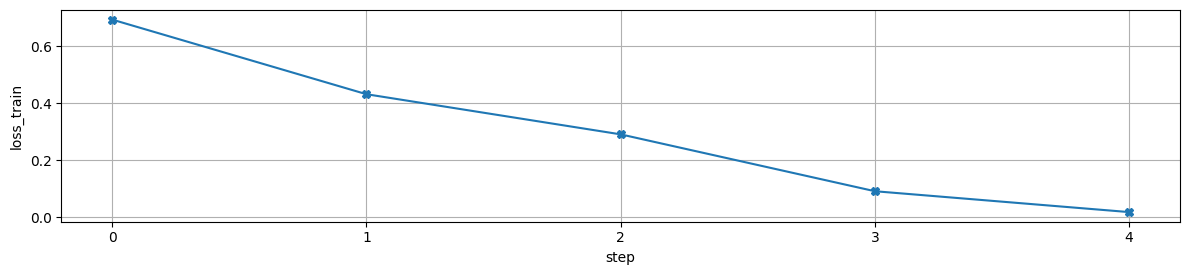

tokenizing: 2845it [00:04, 612.76it/s]


{'0': {'precision': 0.8882104274307187, 'recall': 0.9139681005316578, 'f1-score': 0.9009051929490233, 'support': 2069}, '1': {'precision': 0.6801909307875895, 'recall': 0.6643356643356644, 'f1-score': 0.6721698113207547, 'support': 429}, '2': {'precision': 0.6599326599326599, 'recall': 0.5648414985590778, 'f1-score': 0.6086956521739131, 'support': 347}, 'accuracy': 0.8337434094903339, 'macro avg': {'precision': 0.7427780060503227, 'recall': 0.7143817544754666, 'f1-score': 0.7272568854812304, 'support': 2845}, 'weighted avg': {'precision': 0.8290003221998825, 'recall': 0.8337434094903339, 'f1-score': 0.8307736676880424, 'support': 2845}}
CPU times: user 1h 5min 19s, sys: 7min 36s, total: 1h 12min 55s
Wall time: 1h 12min 32s


In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
reports = []

for i in range(3):
  if i == 0:
    plm, tokenizer, model_config, WrapperClass = load_plm("roberta", "ai-forever/ruRoberta-large")
    train_dataloader = PromptDataLoader(
        dataset=train_datasets[i],
        template=prompt,
        tokenizer=tokenizer,
        tokenizer_wrapper_class=WrapperClass,
        max_seq_length=200,
        batch_size=16,
        teacher_forcing=False,
        predict_eos_token=False,
        truncate_method='balanced',
        shuffle=True
    )
    prompt_model = PromptForClassification(plm=plm, template=prompt, verbalizer=verbalizer, freeze_plm=False)
    prompt_model = prompt_model.to(device)
    loss_func = torch.nn.CrossEntropyLoss()
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters1 = [
      {'params': [p for n, p in prompt_model.plm.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
      {'params': [p for n, p in prompt_model.plm.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer_grouped_parameters2 = [
      {'params': [p for n,p in prompt_model.template.named_parameters() if "raw_embedding" not in n]}
    ]
    optimizer1 = AdamW(optimizer_grouped_parameters1, lr=3e-5)
    optimizer2 = AdamW(optimizer_grouped_parameters2, lr=3e-4)
    total_steps = len(train_dataloader) * 5

    scheduler_1 = transformers.get_linear_schedule_with_warmup(
    optimizer1,
    num_warmup_steps=total_steps*0.1,
    num_training_steps=total_steps)
    scheduler_2 = transformers.get_linear_schedule_with_warmup(
    optimizer2,
    num_warmup_steps=total_steps*0.1,
    num_training_steps=total_steps)
    optimizer1 = AdamW(optimizer_grouped_parameters1, lr=3e-5)
    optimizer2 = AdamW(optimizer_grouped_parameters2, lr=3e-4)
    print(f'Split {i+1}')
    print('-' * 5)
    pp = ProgressPlotter()
    for epoch in range(5):
      total_loss = []
      print('Epoch: ', epoch)
      for step, inputs in enumerate(train_dataloader):
              inputs = inputs.cuda()
              logits = prompt_model(inputs)
              labels = inputs['label']
              loss = loss_func(logits, labels)
              loss.backward()
              total_loss.append(loss.item())
              optimizer1.step()
              scheduler_1.step()
              optimizer1.zero_grad()
              optimizer2.step()
              scheduler_2.step()
              optimizer2.zero_grad()
      pp.add_scalar('loss_train', np.mean(total_loss))
      pp.display([['loss_train']])

    validation_dataloader = PromptDataLoader(dataset=test_datasets[i], template=prompt, tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass, max_seq_length=200,
      batch_size=4, shuffle=False, teacher_forcing=False, predict_eos_token=False,
      truncate_method="balanced")
    allpreds = []
    alllabels = []
    for step, inputs in enumerate(validation_dataloader):
      inputs = inputs.to(device)
      logits = prompt_model(inputs)
      labels = inputs['label']
      alllabels.extend(labels.cpu().tolist())
      allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())
    report = classification_report(alllabels, allpreds, output_dict=True)
    print(report)
    reports.append(report)

#Open Prompt PTR - Prompt 2

In [ ]:
device = torch.device('cuda')

In [ ]:
from openprompt.plms import load_plm
plm, tokenizer, model_config, WrapperClass = load_plm("roberta", "sberbank-ai/ruRoberta-large")

In [ ]:
train_1 = pd.read_csv('tsa_dataset_1_train.csv', sep=';')
test_1 = pd.read_csv('tsa_dataset_1_test.csv', sep='\t')
train_2 = pd.read_csv('tsa_dataset_2_train.csv', sep='\t')
test_2 = pd.read_csv('tsa_dataset_2_test.csv', sep='\t')
train_3 = pd.read_csv('tsa_dataset_3_train.csv', sep='\t')
test_3 = pd.read_csv('tsa_dataset_3_test.csv', sep='\t')

In [ ]:
train_1['label']= train_1['label'].replace([-1, 0, 1], [1, 0, 2])
test_1['label']= test_1['label'].replace([-1, 0, 1], [1, 0, 2])
train_2['label']= train_2['label'].replace([-1, 0, 1], [1, 0, 2])
test_2['label']= test_2['label'].replace([-1, 0, 1], [1, 0, 2])
train_3['label']= train_3['label'].replace([-1, 0, 1], [1, 0, 2])
test_3['label']= test_3['label'].replace([-1, 0, 1], [1, 0, 2])

In [ ]:
splits = [[train_1, train_2, train_3], [test_1, test_2, test_3]]

In [ ]:
train_datasets = []
test_datasets = []
for split in splits[0]:
  dataset_train = []
  for i, sentence in enumerate(split['sentence']):
    entity = split['entity'][i]
    label = split['label'][i]
    dataset_train.append(InputExample(text_a=entity, text_b=sentence, label=label, guid=i))
  train_datasets.append(dataset_train)

for split in splits[1]:
  dataset_test = []
  for i, sentence in enumerate(split['sentence']):
    entity = split['entity'][i]
    label = split['label'][i]
    dataset_test.append(InputExample(text_a=entity, text_b=sentence, label=label, guid=i))
  test_datasets.append(dataset_test)

# RuSentiFrames Parser

In [ ]:
import json
import re

aux = open("frames20201001utf (2).json", encoding='utf-8-sig')
with open ('new_file.txt', "w") as new:
  for l in aux:
    l1=l.replace("“", "\"")
    l2=l1.replace("”", "\"")
    l3=re.sub(r'\[(?=\"[aа][0123]\":)', '', l2)
    l33=re.sub(r"(?<=((\"[aа]0\":)|(\"[аa]1\":)|(\"[aа]2\":)|(\"[аa]3\":)))""(?=\s\")", ' [', l3)
    new.write(l33)
   # new.write ('\n')
frames = json.load(open("new_file.txt", encoding="utf-8"))

In [ ]:
prompt_dict = {}

for value in frames.values():
  if 'polarity' in value['frames'].keys():
    prepare_list = value['frames']['polarity']
    predicates = value['variants']
    for pred in predicates:
        prompt_dict[pred] = prepare_list

In [ ]:
neg_verb, pos_verb = [], []
for key, val in prompt_dict.items():
  if 'pos' in str(val):
    pos_verb.append(key)
  if 'neg' in str(val):
    neg_verb.append(key)

In [ ]:
print(len(neg_verb))
print(len(pos_verb))

4216
3827


#RuSentiLex Parser

In [ ]:
words_pos = []
words_neg = []
with open('rusentilex_2017 (1) (1).txt', 'r') as f:
  for line in f:
    if not(line.startswith('!') or line.startswith('\n')):
      dict_info = line.split(',')
      if dict_info[3] == ' positive':
        words_pos.append(dict_info[0].strip())
      if dict_info[3] == ' negative':
        words_neg.append(dict_info[0].strip())



In [ ]:
print(len(words_pos))
print(len(words_neg))

5424
12595


In [ ]:
for elem in neg_verb:
  if elem not in words_neg:
      words_neg.append(elem)

for elem in pos_verb:
  if elem not in words_pos:
    words_pos.append(elem)

In [ ]:
words_neg = [word for word in words_neg if word not in words_pos]

In [ ]:
words_neut = ['нейтрально', "нейтральное"]

In [ ]:
with open('knowledge.txt', 'w') as ff:
  ff.write(','.join(words_neut))
  ff.write('\n')
  ff.write(','.join(words_neg))
  ff.write('\n')
  ff.write(','.join(words_pos))

In [ ]:
plm, tokenizer, model_config, WrapperClass = load_plm("roberta", "ai-forever/ruRoberta-large")

In [ ]:
prompt = MixedTemplate(
    model=plm,
    tokenizer=tokenizer,
    text='{"soft": "Какие слова описывают тональность отношения к "}{"placeholder": "text_a"}{"soft": " в новостном тексте "}{"placeholder": "text_b"}?{"mask"}'
    )


In [ ]:
verbalizer = KnowledgeableVerbalizer(
    tokenizer=tokenizer,
    num_classes=3).from_file('knowledge.txt')

##Num of label words for each label: [2, 12485, 8425]


In [ ]:
train_1 = pd.read_csv('tsa_dataset_1_train.csv', sep=';')
test_1 = pd.read_csv('tsa_dataset_1_test.csv', sep='\t')
train_2 = pd.read_csv('tsa_dataset_2_train.csv', sep='\t')
test_2 = pd.read_csv('tsa_dataset_2_test.csv', sep='\t')
train_3 = pd.read_csv('tsa_dataset_3_train.csv', sep='\t')
test_3 = pd.read_csv('tsa_dataset_3_test.csv', sep='\t')


In [ ]:
train_1['label']= train_1['label'].replace([-1, 0, 1], [1, 0, 2])
test_1['label']= test_1['label'].replace([-1, 0, 1], [1, 0, 2])
train_2['label']= train_2['label'].replace([-1, 0, 1], [1, 0, 2])
test_2['label']= test_2['label'].replace([-1, 0, 1], [1, 0, 2])
train_3['label']= train_3['label'].replace([-1, 0, 1], [1, 0, 2])
test_3['label']= test_3['label'].replace([-1, 0, 1], [1, 0, 2])

In [ ]:
train_datasets = []
test_datasets = []
for split in splits[0]:
  dataset_train = []
  for i, sentence in enumerate(split['sentence']):
    entity = split['entity'][i]
    label = split['label'][i]
    dataset_train.append(InputExample(text_a=entity, text_b=sentence, label=label, guid=i))
  train_datasets.append(dataset_train)

for split in splits[1]:
  dataset_test = []
  for i, sentence in enumerate(split['sentence']):
    entity = split['entity'][i]
    #label = split['label'][i]
    dataset_test.append(InputExample(text_a=entity, text_b=sentence, guid=i, label=label))
  test_datasets.append(dataset_test)

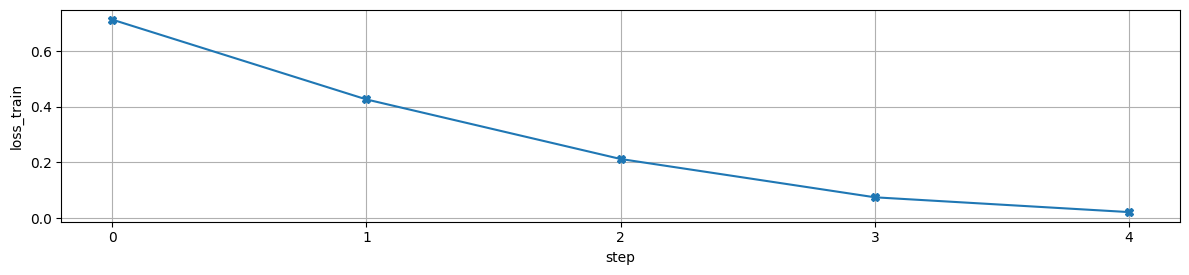

CPU times: user 59min 28s, sys: 8min 57s, total: 1h 8min 26s
Wall time: 1h 8min 42s


'\n    validation_dataloader = PromptDataLoader(dataset=test_datasets[i], template=prompt, tokenizer=tokenizer,\n    tokenizer_wrapper_class=WrapperClass, max_seq_length=200,\n      batch_size=4, shuffle=False, teacher_forcing=False, predict_eos_token=False,\n      truncate_method="balanced")\n    allpreds = []\n    alllabels = []\n    for step, inputs in enumerate(validation_dataloader):\n      inputs = inputs.to(device)\n      logits = prompt_model(inputs)\n      labels = inputs[\'label\']\n      alllabels.extend(labels.cpu().tolist())\n      allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())\n    report = classification_report(alllabels, allpreds, output_dict=True)\n    print(report)\n    reports.append(report)\n'

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
reports = []

for i in range(3):
    plm, tokenizer, model_config, WrapperClass = load_plm("roberta", "ai-forever/ruRoberta-large")
    train_dataloader = PromptDataLoader(
        dataset=train_datasets[i],
        template=prompt,
        tokenizer=tokenizer,
        tokenizer_wrapper_class=WrapperClass,
        max_seq_length=200,
        batch_size=16,
        teacher_forcing=False,
        predict_eos_token=False,
        truncate_method='balanced',
        shuffle=True
    )

    prompt_model = PromptForClassification(plm=plm, template=prompt, verbalizer=verbalizer, freeze_plm=False)
    prompt_model = prompt_model.to(device)
    loss_func = torch.nn.CrossEntropyLoss()
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters1 = [
      {'params': [p for n, p in prompt_model.plm.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
      {'params': [p for n, p in prompt_model.plm.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer_grouped_parameters2 = [
      {'params': [p for n,p in prompt_model.template.named_parameters() if "raw_embedding" not in n]}
    ]
    optimizer1 = AdamW(optimizer_grouped_parameters1, lr=3e-5)
    optimizer2 = AdamW(optimizer_grouped_parameters2, lr=3e-4)
    total_steps = len(train_dataloader) * 5

    scheduler_1 = transformers.get_linear_schedule_with_warmup(
    optimizer1,
    num_warmup_steps=total_steps*0.1,
    num_training_steps=total_steps)
    scheduler_2 = transformers.get_linear_schedule_with_warmup(
    optimizer2,
    num_warmup_steps=total_steps*0.1,
    num_training_steps=total_steps)
    optimizer1 = AdamW(optimizer_grouped_parameters1, lr=3e-5)
    optimizer2 = AdamW(optimizer_grouped_parameters2, lr=3e-4)
    print(f'Split {i+1}')
    print('-' * 5)
    pp = ProgressPlotter()
    for epoch in range(5):
      total_loss = []
      print('Epoch: ', epoch+1)
      for step, inputs in enumerate(train_dataloader):
              inputs = inputs.cuda()
              logits = prompt_model(inputs)
              labels = inputs['label']
              loss = loss_func(logits, labels)
              loss.backward()
              total_loss.append(loss.item())
              optimizer1.step()
              scheduler_1.step()
              optimizer1.zero_grad()
              optimizer2.step()
              scheduler_2.step()
              optimizer2.zero_grad()
      pp.add_scalar('loss_train', np.mean(total_loss))
      pp.display([['loss_train']])
    validation_dataloader = PromptDataLoader(dataset=test_datasets[i], template=prompt, tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass, max_seq_length=200,
      batch_size=4, shuffle=False, teacher_forcing=False, predict_eos_token=False,
      truncate_method="balanced")
    allpreds = []
    alllabels = []
    for step, inputs in enumerate(validation_dataloader):
      inputs = inputs.to(device)
      logits = prompt_model(inputs)
      labels = inputs['label']
      alllabels.extend(labels.cpu().tolist())
      allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())
    report = classification_report(alllabels, allpreds, output_dict=True)
    print(report)
    reports.append(report)
